## Region Segmentation using Traditional Techniques

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def edge_segmentation(gray):
    """
    Example using Canny + morphological ops + contour filling.
    You may need to refine to isolate the 'mask' region specifically.
    """
    edges = cv2.Canny(gray, 50, 150)
    kernel = np.ones((5,5), np.uint8)
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Find contours and fill them
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray, dtype=np.uint8)
    cv2.drawContours(mask, contours, -1, color=255, thickness=cv2.FILLED)
    return mask

In [ ]:
def compute_iou(pred_mask, gt_mask):
    pred_bin = (pred_mask > 0).astype(np.uint8)
    gt_bin   = (gt_mask > 0).astype(np.uint8)
    intersection = np.logical_and(pred_bin, gt_bin).sum()
    union        = np.logical_or(pred_bin, gt_bin).sum()
    return intersection / union if union != 0 else 0.0

In [ ]:
def visualize_results(original, pred_mask, gt_mask, method="Threshold"):
    """
    Visualize original image, predicted segmentation, ground truth, side-by-side.
    """
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(original_rgb)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(pred_mask, cmap="gray")
    plt.title(f"{method} Prediction")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(gt_mask, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

[008046_1.jpg] Edge Detection IoU: 0.4635


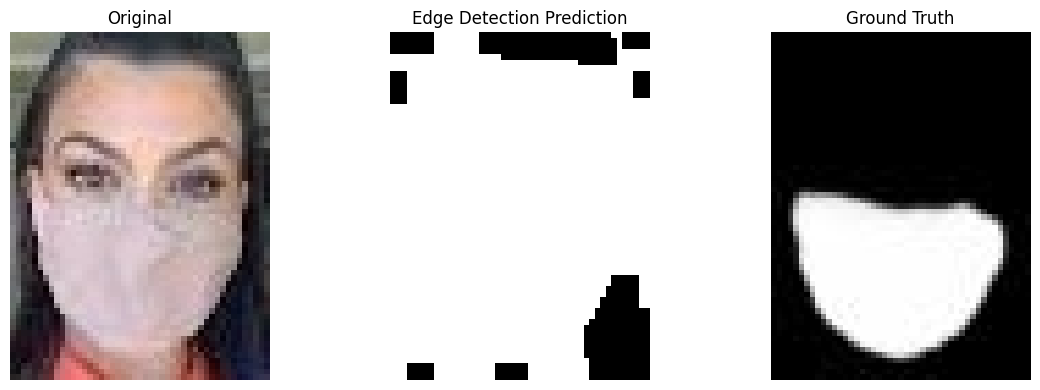

[008003_1.jpg] Edge Detection IoU: 0.3960


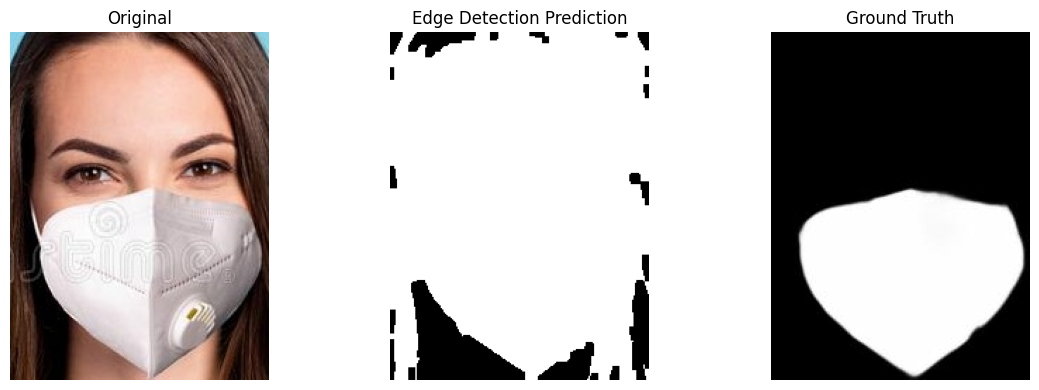

[007955_1.jpg] Edge Detection IoU: 0.0802


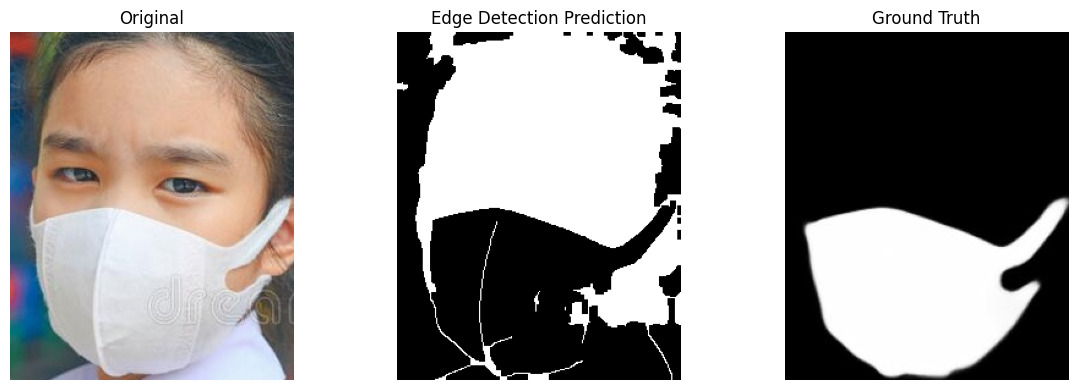

[007910_1.jpg] Edge Detection IoU: 0.4105


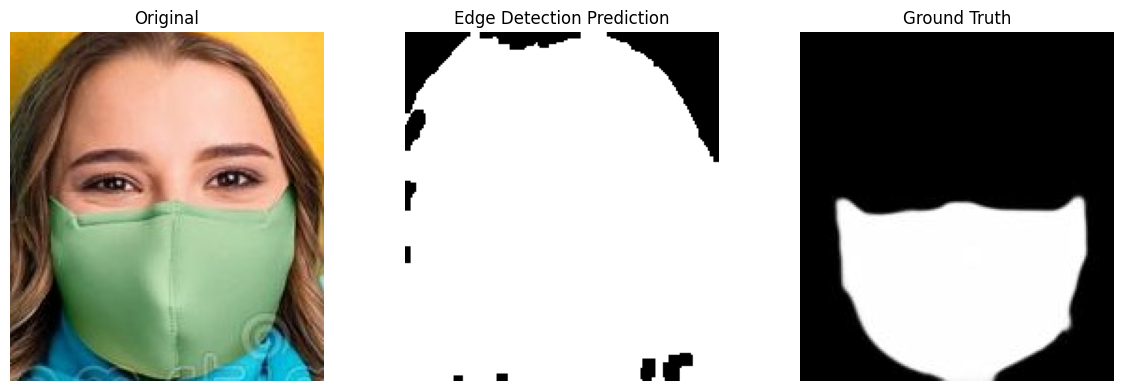

[008225_12.jpg] Edge Detection IoU: 0.1906


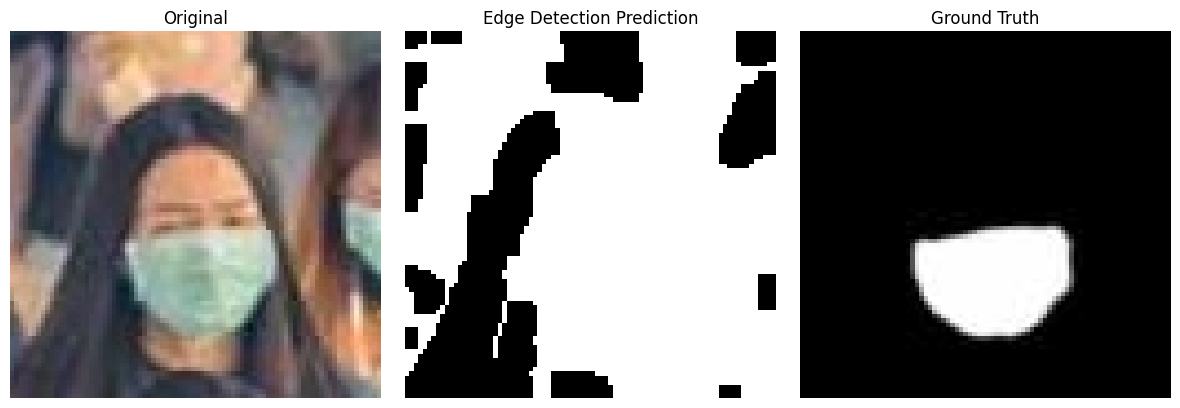

[007995_1.jpg] Edge Detection IoU: 0.1775


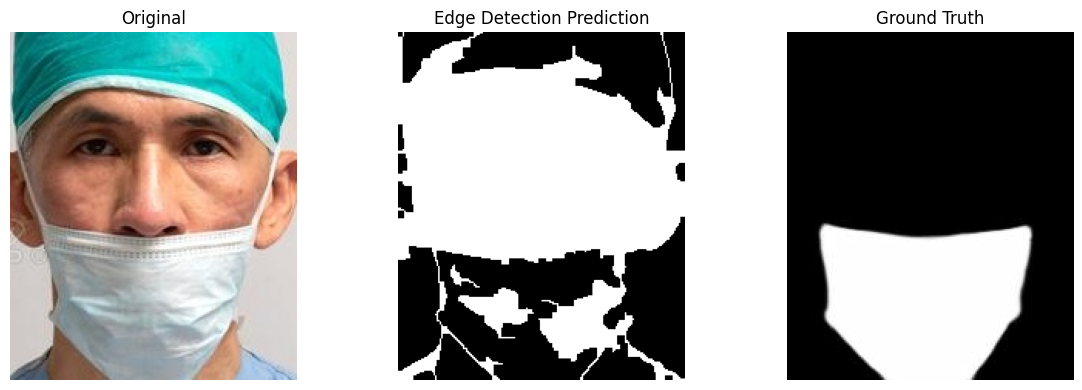

[008086_1.jpg] Edge Detection IoU: 0.2061


[007968_1.jpg] Edge Detection IoU: 0.3193


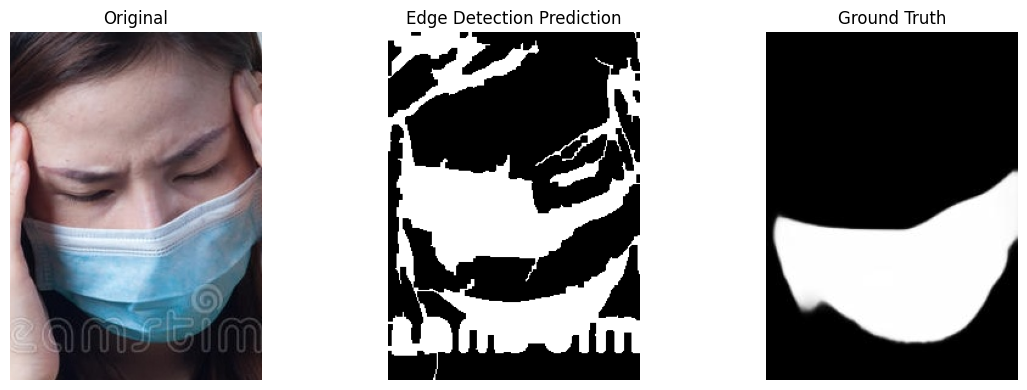

[008123_1.jpg] Edge Detection IoU: 0.4143


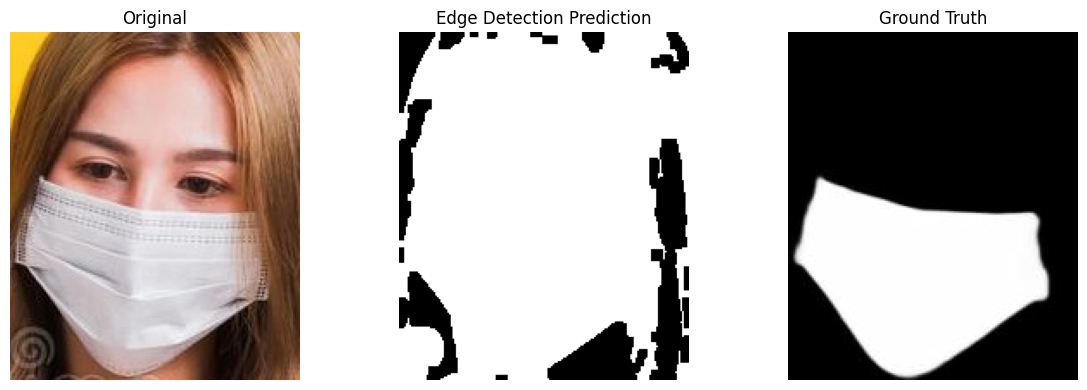

[008166_1.jpg] Edge Detection IoU: 0.3723


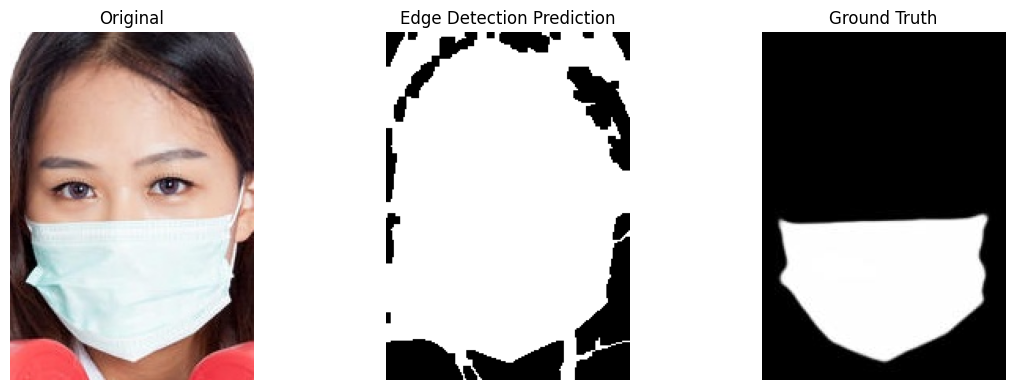

[007875_1.jpg] Edge Detection IoU: 0.1039


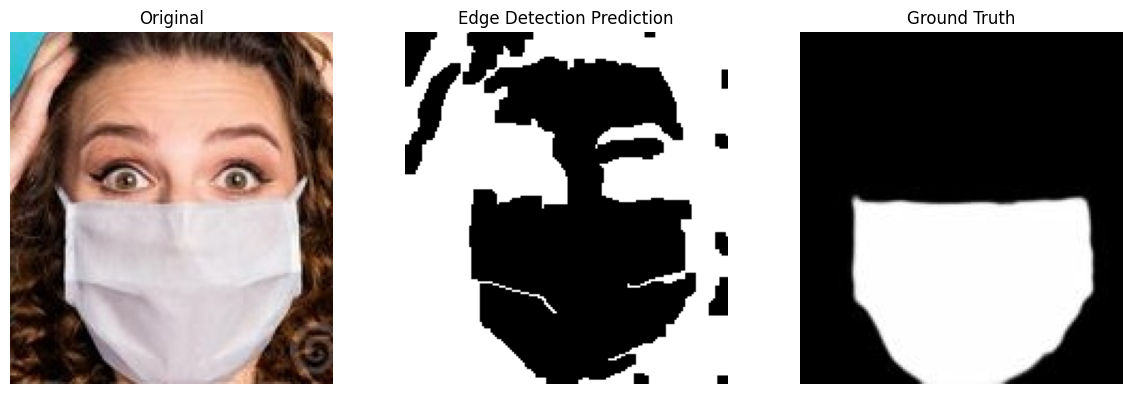

[008222_1.jpg] Edge Detection IoU: 0.5968


[007888_1.jpg] Edge Detection IoU: 0.5296


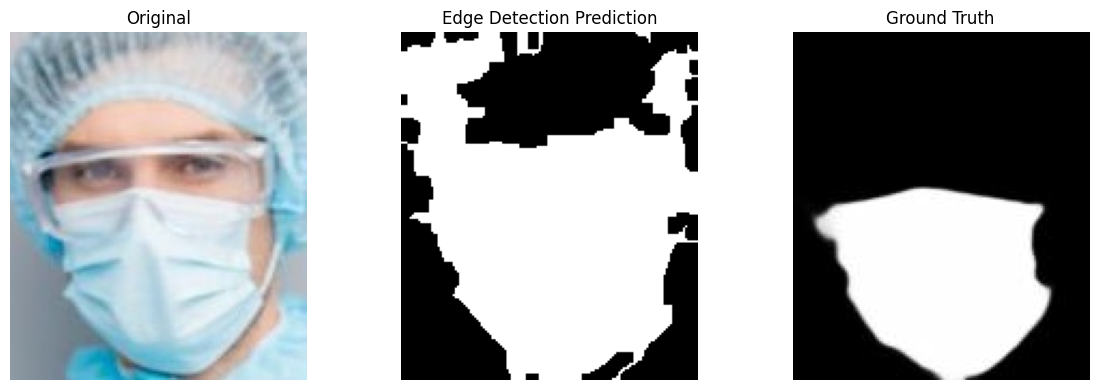

[007909_1.jpg] Edge Detection IoU: 0.3448


[008206_1.jpg] Edge Detection IoU: 0.2640


[007851_1.jpg] Edge Detection IoU: 0.3452


[008107_1.jpg] Edge Detection IoU: 0.0546


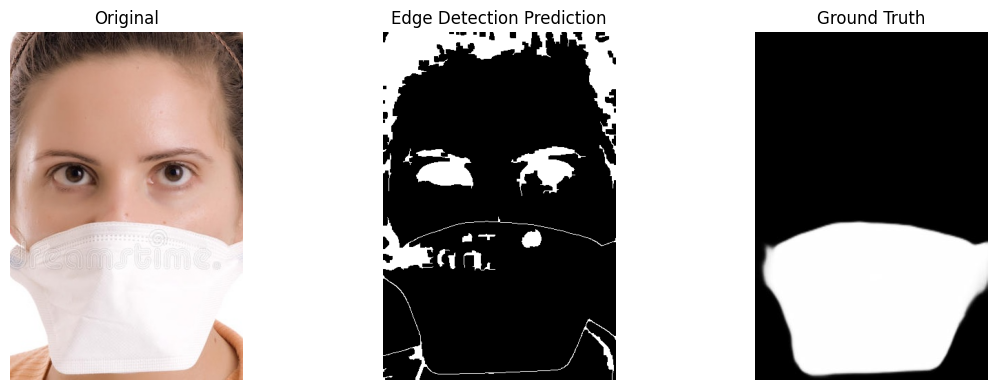

[008142_1.jpg] Edge Detection IoU: 0.4821


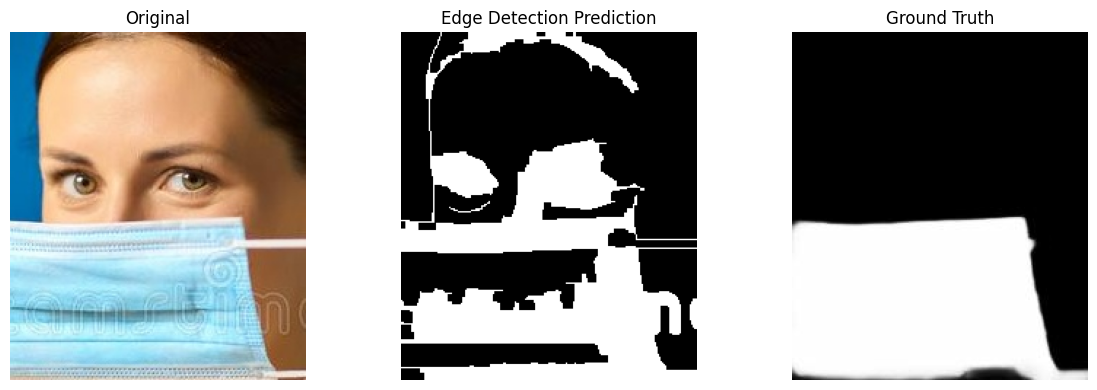

[008225_13.jpg] Edge Detection IoU: 0.1464


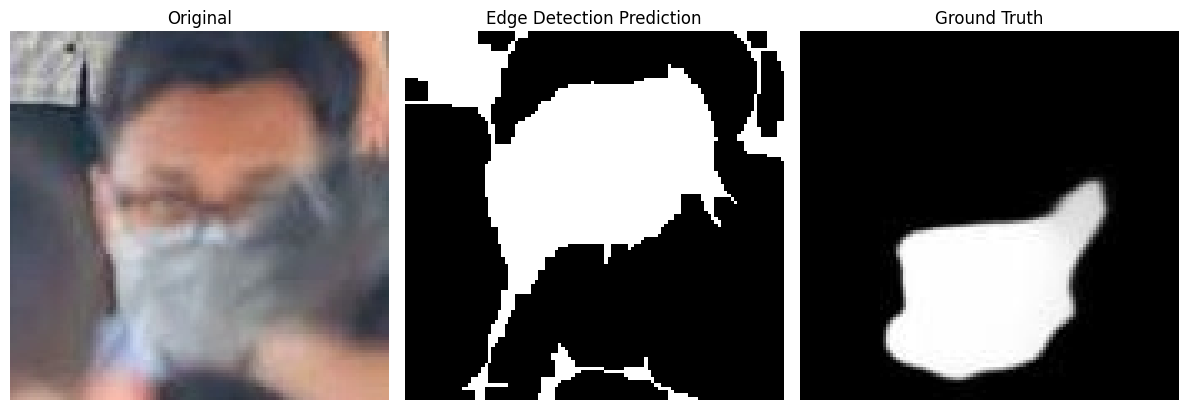

[008182_1.jpg] Edge Detection IoU: 0.3787


Mean IoU across 383 images: 0.3410


In [ ]:
def main():
    face_dir = "C:/datasets/MSFD/1/face_crop"
    seg_dir = "C:/datasets/MSFD/1/face_crop_segmentation"
    
    image_files = [f for f in os.listdir(face_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    ious = []  # to store IoU for each image

    for i, img_name in enumerate(image_files):
        img_path = os.path.join(face_dir, img_name)

        base_name = os.path.splitext(img_name)[0]
        gt_name = base_name + ".jpg"
        gt_path = os.path.join(seg_dir, gt_name)

        original = cv2.imread(img_path)
        gt_mask  = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

        if original is None or gt_mask is None:
            print(f"Could not load either {img_path} or {gt_path}. Skipping...")
            continue

        # Convert to grayscale for segmentation
        gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

        # Edge-based segmentation
        edge_pred = edge_segmentation(gray)
        edge_iou  = compute_iou(edge_pred, gt_mask)
        ious.append(edge_iou)

        # Only visualize for the first 20 images
        if i < 20:
            print(f"[{img_name}] Edge Detection IoU: {edge_iou:.4f}")
            visualize_results(original, edge_pred, gt_mask, method="Edge Detection")

    # Compute and print mean IoU across all processed images
    if len(ious) > 0:
        mean_iou = np.mean(ious)
        print(f"Mean IoU across {len(ious)} images: {mean_iou:.4f}")
    else:
        print("No images were processed. Check file paths and naming.")

if __name__ == "__main__":
    main()

## Mask Segmentation using UNET

In [33]:
!pip install segmentation-models tensorflow opencv-python numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\kusha\\AppData\\Roaming\\Python\\Python311\\site-packages\\cv2\\cv2.pyd'
Check the permissions.



### UNET Training

In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Use TensorFlow backend
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `tf.keras` framework.


In [2]:
import tensorflow as tf
import os

# Define dataset paths
image_dir = "C:/datasets/MSFD/1/face_crop"
mask_dir = "C:/datasets/MSFD/1/face_crop_segmentation"
image_size = 128  # Resize images
batch_size = 16

# Get filenames without paths
image_files = set(os.listdir(image_dir))
mask_files = set(os.listdir(mask_dir))

# Find matching pairs
matched_image_paths = []
matched_mask_paths = []

# Track outliers
missing_masks = []
missing_images = []

for img_file in image_files:
    if img_file in mask_files:
        matched_image_paths.append(os.path.join(image_dir, img_file))
        matched_mask_paths.append(os.path.join(mask_dir, img_file))
    else:
        missing_masks.append(img_file)  # Image has no mask

for mask_file in mask_files:
    if mask_file not in image_files:
        missing_images.append(mask_file)  # Mask has no image

# Print missing files
if missing_masks:
    print("❌ Images without masks:", missing_masks)
if missing_images:
    print("❌ Masks without images:", missing_images)

# Function to load & preprocess images dynamically
def load_image(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  
    img = tf.image.resize(img, (image_size, image_size)) / 255.0  # Normalize

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  
    mask = tf.image.resize(mask, (image_size, image_size)) / 255.0  # Normalize (0 or 1)

    return img, mask

# Create TensorFlow Dataset (Loads batch-by-batch)
dataset = tf.data.Dataset.from_tensor_slices((matched_image_paths, matched_mask_paths))
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)  
dataset = dataset.batch(batch_size).shuffle(1000).prefetch(tf.data.AUTOTUNE)

print("Dataset created successfully.")

Dataset created successfully.


In [5]:
print(len(image_files), len(mask_files))
# image_files[-5:], mask_files[-5:]

9000 9000


In [6]:
# Define the model
BACKBONE = 'resnet34'
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=1, activation='sigmoid')

# Compile model with Dice Loss and Adam optimizer
model.compile(
    optimizer='adam',
    loss=sm.losses.binary_focal_dice_loss,  # Better for segmentation
    metrics=[sm.metrics.iou_score]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)             │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_data (BatchNormalization)  │ (None, None, None, 3)     │               9 │ data[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, None, None, 3)     │               0 │ bn_data[0][0]              │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv0 (Conv2D)                │ (None, None, None, 64)    │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn0 (BatchNormalization)      │ (None, None, None, 64)    │             256 │ conv0[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ relu0 (Activation)            │ (None, None, None, 64)    │               0 │ bn0[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, None, None, 64)    │               0 │ relu0[0][0]                │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooling0 (MaxPooling2D)       │ (None, None, None, 64)    │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_bn1              │ (None, None, None, 64)    │             256 │ pooling0[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_relu1            │ (None, None, None, 64)    │               0 │ stage1_unit1_bn1[0][0]     │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_2              │ (None, None, None, 64)    │               0 │ stage1_unit1_relu1[0][0]   │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_conv1 (Conv2D)   │ (None, None, None, 64)    │          36,864 │ zero_padding2d_2[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_bn2              │ (None, None, None, 64)    │             256 │ stage1_unit1_conv1[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_relu2            │ (None, None, None, 64)    │               0 │ stage1_unit1_bn2[0][0]     │
│ (Activation)                  │                           │               

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [7]:
model.fit(dataset, epochs=10)

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1519s 3s/step - iou_score: 0.7574 - loss: 0.1929
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1436s 3s/step - iou_score: 0.8753 - loss: 0.0977
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1532s 3s/step - iou_score: 0.8892 - loss: 0.0867
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1454s 3s/step - iou_score: 0.8920 - loss: 0.0844
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1522s 3s/step - iou_score: 0.9015 - loss: 0.0766
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1394s 2s/step - iou_score: 0.9029 - loss: 0.0755
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1396s 2s/step - iou_score: 0.9085 - loss: 0.0712
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1395s 2s/step - iou_score: 0.9137 - loss: 0.0679
Epoch 9/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1388s 2s/step - iou_score: 0.9158 - loss: 0.0659
Epoch 10/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1389s 2s/step - iou_score: 0.9160 - loss: 0.0657


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


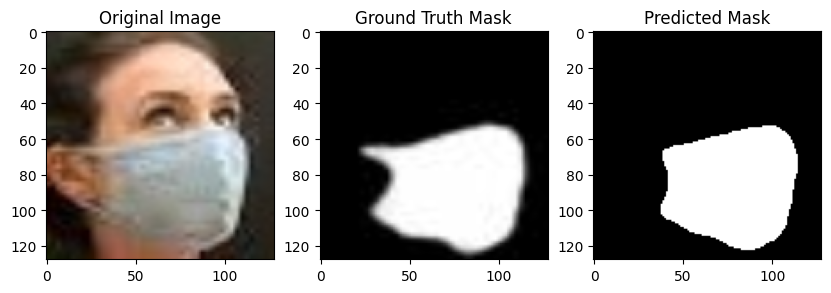

In [8]:
# Take one batch from the dataset
for images, masks in dataset.take(1):
    predictions = model.predict(images)
    predicted_masks = (predictions > 0.5).astype("uint8")

    # Show an example
    index = 5  # Pick a sample
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(images[index])  # Original Image
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(masks[index].numpy().squeeze(), cmap='gray')  # Ground Truth Mask
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[index].squeeze(), cmap='gray')  # Predicted Mask
    plt.title("Predicted Mask")

    plt.show()


In [9]:
model.save("facemask_unet_model.keras")

In [10]:
for images, masks in dataset.take(5):
    predictions = model.predict(images)
    predicted_masks = (predictions > 0.5).astype("uint8")

    # Show an example
    index = 5  # Pick a sample
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(images[index])  # Original Image
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(masks[index].numpy().squeeze(), cmap='gray')  # Ground Truth Mask
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[index].squeeze(), cmap='gray')  # Predicted Mask
    plt.title("Predicted Mask")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


In [11]:
img = dataset.take(1)
type(img)

tensorflow.python.data.ops.take_op._TakeDataset

### UNET Testing

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
test_image_dir = "C:/datasets/MSFD/test_images"  # Folder with test images
output_mask_dir = "C:/datasets/MSFD/test_masks"  # Folder to save predicted masks

os.makedirs(output_mask_dir, exist_ok=True)  # Create output folder if not exists

In [3]:
model = tf.keras.models.load_model("facemask_unet_model.keras", compile=False)

In [4]:
image_size = 128  # Resize to match training
threshold = 0.5  # Mask threshold

# Get test image file paths
test_image_paths = [os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


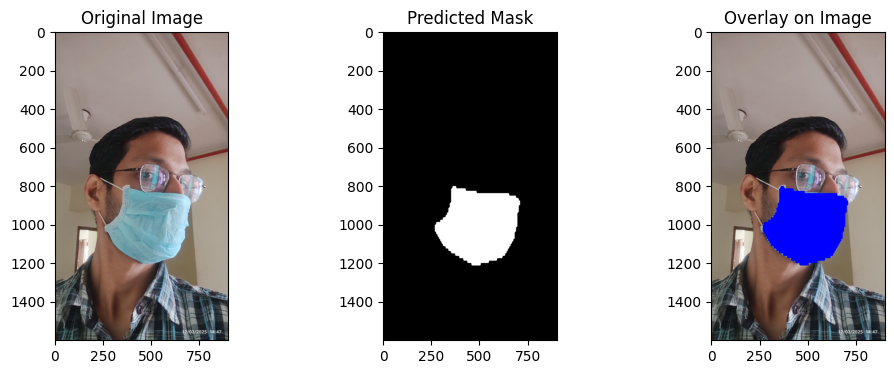

✅ Saved mask for IMG-20250312-WA0007.jpg at C:/datasets/MSFD/test_masks\IMG-20250312-WA0007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


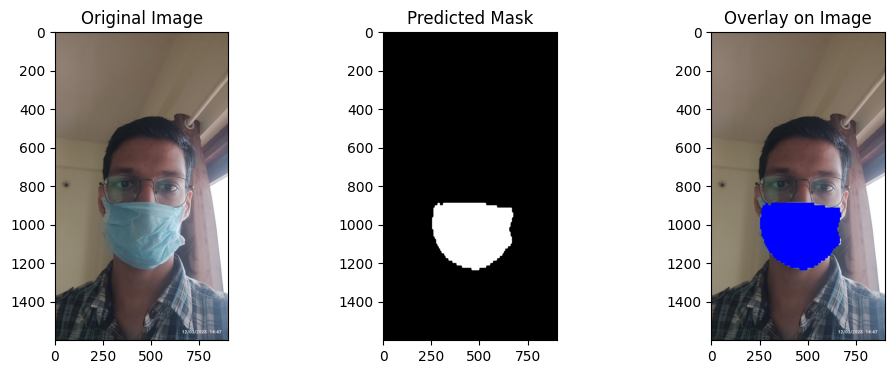

✅ Saved mask for IMG-20250312-WA0008.jpg at C:/datasets/MSFD/test_masks\IMG-20250312-WA0008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


✅ Saved mask for IMG-20250312-WA0009.jpg at C:/datasets/MSFD/test_masks\IMG-20250312-WA0009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


✅ Saved mask for IMG-20250312-WA0010.jpg at C:/datasets/MSFD/test_masks\IMG-20250312-WA0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


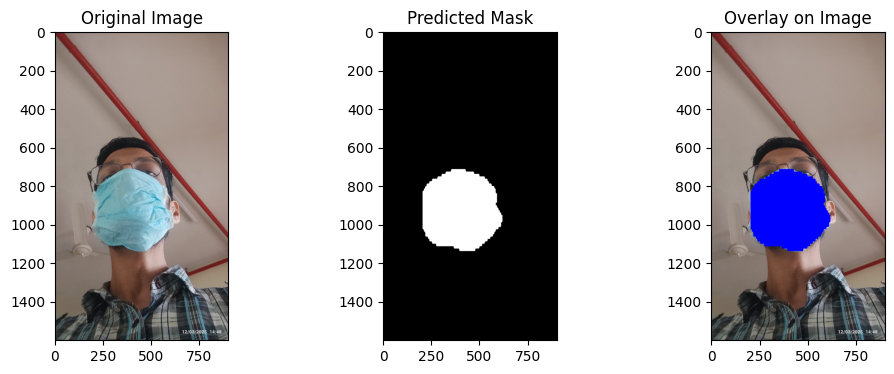

✅ Saved mask for IMG-20250312-WA0011.jpg at C:/datasets/MSFD/test_masks\IMG-20250312-WA0011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


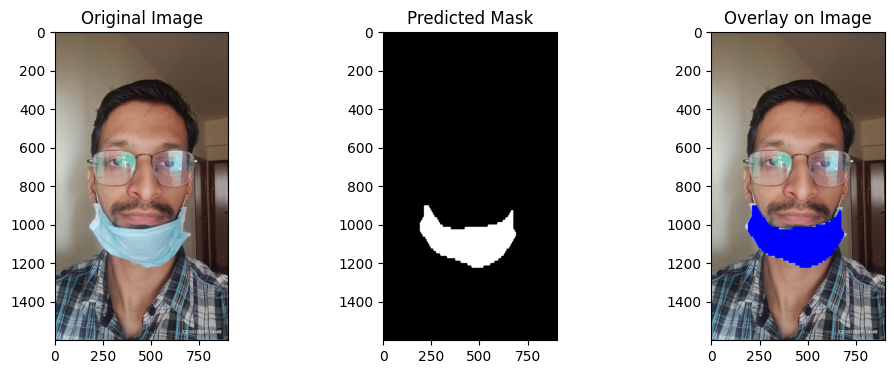

✅ Saved mask for IMG-20250312-WA0012.jpg at C:/datasets/MSFD/test_masks\IMG-20250312-WA0012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


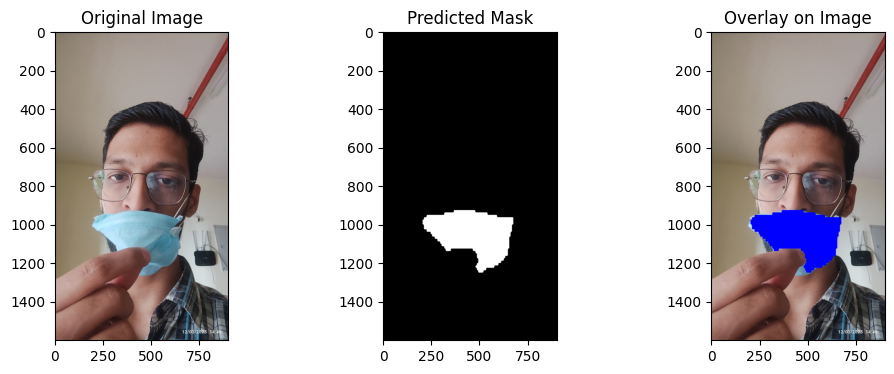

✅ Saved mask for IMG-20250312-WA0013.jpg at C:/datasets/MSFD/test_masks\IMG-20250312-WA0013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


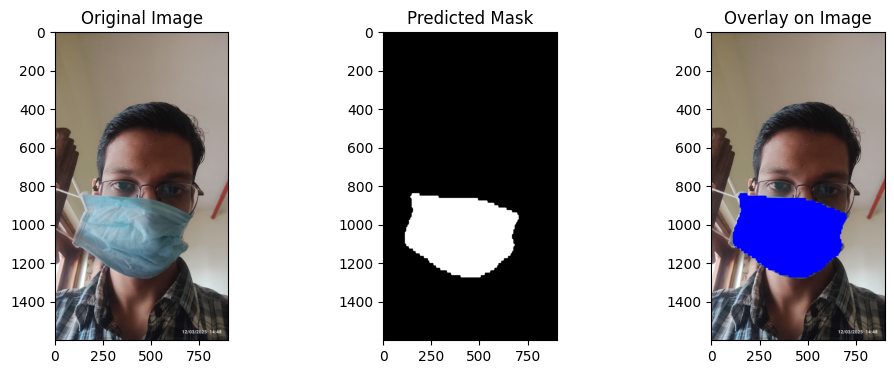

✅ Saved mask for IMG-20250312-WA0014.jpg at C:/datasets/MSFD/test_masks\IMG-20250312-WA0014.jpg


In [5]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    img = img / 255.0  # Normalize
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Process each test image
for image_path in test_image_paths:
    filename = os.path.basename(image_path)
    
    # Preprocess & predict
    test_img = preprocess_image(image_path)
    predicted_mask = model.predict(test_img)[0]  # Remove batch dim
    binary_mask = (predicted_mask > threshold).astype(np.uint8)  # Convert to binary
    
    # Resize mask to match original image size
    original_img = cv2.imread(image_path)
    resized_mask = cv2.resize(binary_mask, (original_img.shape[1], original_img.shape[0]))
    
    # Save mask as PNG
    mask_output_path = os.path.join(output_mask_dir, filename)
    cv2.imwrite(mask_output_path, resized_mask * 255)  # Save mask as grayscale
    
    # Overlay mask on original image
    overlay = original_img.copy()
    overlay[resized_mask == 1] = [255, 0, 0]  # Red mask overlay

    # Show results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(resized_mask, cmap='gray')
    plt.title("Predicted Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Overlay on Image")

    plt.savefig(f"./figoutput/{filename}")
    plt.show()

    print(f"✅ Saved mask for {filename} at {mask_output_path}")
